Data Exploration
===

In [1]:
import json
from pathlib import Path

import lightgbm as lgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data_dir = (Path.cwd() / ".." / "data").resolve()
assert data_dir.exists()

In [3]:
!du -h {data_dir}/* | sort -hr

 57M	/Users/levoniaz/repos/biomarker-case-study/data/biomarkers.csv
576K	/Users/levoniaz/repos/biomarker-case-study/data/patient_profiles.json
 36K	/Users/levoniaz/repos/biomarker-case-study/data/targets.csv


In [4]:
tdf = pd.read_csv(data_dir / "targets.csv")
display(tdf.sample(n=3))
tdf.shape

,patient_id,biomarker_id,target_label
1062,86c0772d,1891bedcd,0
1128,a061b6bc,1f3aa14e6,0
601,1f7f88e62,122fd10d6,0


(1734, 3)

In [5]:
bdf = pd.read_csv(data_dir / "biomarkers.csv")
display(bdf.sample(n=3))
bdf.shape

,biomarker_id,BM00000,BM00001,BM00002,BM00003,BM00004,BM00005,BM00006,BM00007,BM00008,...,BM15147,BM15148,BM15149,BM15150,BM15151,BM15152,BM15153,BM15154,BM15155,BM15156
1027,21c928d36,0,1,1,0,0,0,0,1,1,...,1,0,1,0,0,0,1,1.0,1,1
258,142a02711,1,1,1,0,0,0,0,0,1,...,1,0,0,1,0,1,1,NaN,1,1
1475,680aeb42,0,1,1,0,1,0,1,0,1,...,1,0,0,0,0,0,1,1.0,1,1


(1960, 15158)

In [6]:
assert bdf["biomarker_id"].nunique() == len(bdf), "biomarker_id expected to be unique"
bdf = bdf.set_index("biomarker_id")

In [7]:
(bdf.nunique(dropna=False) > 2).sum()

44

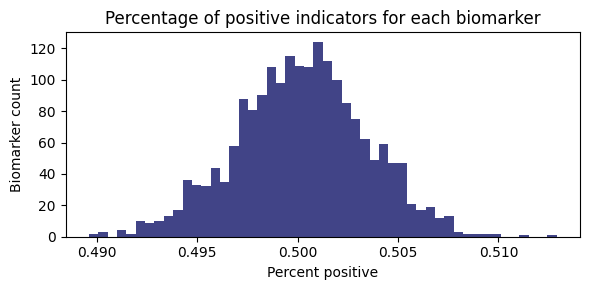

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
pct_pos = bdf.sum(axis=1) / len(bdf.columns)

ax.hist(pct_pos, bins=50, color=matplotlib.cm.viridis(0.2))
ax.set_title("Percentage of positive indicators for each biomarker")
ax.set_ylabel("Biomarker count")
ax.set_xlabel("Percent positive")

fig.tight_layout()
plt.show()

In [9]:
# confirm: only boolean and NA values in the biomarker data
np.unique(bdf.to_numpy().flatten(), return_counts=True)

(array([ 0.,  1., nan]), array([14812175, 14860033,    35512]))

In [10]:
pdf = pd.read_json(data_dir / "patient_profiles.json")
pdf.shape

(7, 3)

In [11]:
# nested JSON structure... let's use a different approach to load this data
# (note a more general approach that is less specific to this dataset
# could use a library like JMESPath)
pdf.patient_profiles.map(pd.DataFrame).iloc[0].sample(5)

,patient_id,demographics,status
89,1d5754703,"{'gender': 'Female', 'age': 61}","{'disease_sub_type': 'C', 'comorbidity_index':..."
108,2017c9182,"{'gender': 'Male', 'age': 71}","{'disease_sub_type': 'A', 'comorbidity_index':..."
92,1dab425f4,"{'gender': 'Female', 'age': 43, 'race': 'White'}","{'disease_sub_type': 'B', 'comorbidity_index':..."
214,a4375c02,"{'gender': 'Male', 'age': 54, 'race': 'Black o...","{'disease_sub_type': 'A', 'comorbidity_index':..."
86,1c9af69ad,"{'gender': 'Male', 'age': 69, 'race': 'Black o...","{'disease_sub_type': 'A', 'comorbidity_index':..."


In [12]:
with open(data_dir / "patient_profiles.json") as infile:
    institution_list = json.load(infile)

In [13]:
def get_patient_profiles(institution_list):
    for institution in institution_list:
        institution_name = institution["institution"]
        cohort_id = institution["cohort_id"]
        for patient_profile in institution["patient_profiles"]:
            d = {
                "institution_name": institution_name,
                "cohort_id": cohort_id,
            }
            for key, value in patient_profile.items():
                if type(value) == dict:
                    d.update({key + "_" + k: v for k, v in value.items()})
                else:
                    d[key] = value
            yield d

In [14]:
pdf = pd.DataFrame(get_patient_profiles(institution_list))
pdf.shape

(2351, 15)

In [15]:
pdf.sample(n=3)

,institution_name,cohort_id,patient_id,demographics_gender,demographics_age,status_disease_sub_type,status_comorbidity_index,status_cohort_qualifier,status_smoking_status,status_months_since_diagnosis,demographics_race,status_days_since_diagnosis,status_alcohol_usage,status_exercise_frequency,status_bmi_level
426,"BioLab, Inc.",14562556998,1755d2010,Female,65.0,B,NaN,True,current,0.0,White,NaN,NaN,NaN,NaN
738,"BioLab, Inc.",14562556998,3435793d,Male,58.0,A,NaN,True,current,8.0,White,NaN,NaN,NaN,NaN
609,"BioLab, Inc.",14562556998,1fd19b6ee,Male,53.0,A,0.0,True,current,1.0,White,NaN,NaN,NaN,NaN


In [16]:
# note: patient_id is unique across institutions
unique_counts = pdf.nunique().rename("# unique")
na_counts = pdf.isna().sum(axis=0).rename("# NA")
cdf = pd.concat(
    [unique_counts, (unique_counts / len(pdf)).rename("% unique"), na_counts, (na_counts / len(pdf)).rename("% NA")],
    axis=1,
)
cdf.sort_values(by="# NA", ascending=False)

,# unique,% unique,# NA,% NA
status_days_since_diagnosis,86,0.036580,2219,0.943854
status_bmi_level,4,0.001701,2085,0.886857
status_alcohol_usage,4,0.001701,1973,0.839217
status_exercise_frequency,3,0.001276,1973,0.839217
status_comorbidity_index,3,0.001276,1866,0.793705
demographics_race,10,0.004254,593,0.252233
demographics_age,59,0.025096,132,0.056146
status_smoking_status,8,0.003403,132,0.056146
status_months_since_diagnosis,68,0.028924,132,0.056146
institution_name,7,0.002977,0,0.000000


In [17]:
for column in pdf.columns:
    if pdf[column].nunique() < 20:
        sdf = pdf[column].value_counts(dropna=False).to_frame()
        display(sdf)

,institution_name
"BioLab, Inc.",793
Medical Information Exchange,394
Montague Hospital,378
University Hospital System,335
Saint Penelope Medical Center,257
Goodfellow Research Institute,132
Johnson & Bloom Hospitals,62


,cohort_id
14562556998,2351


,demographics_gender
Male,1036
Female,937
MALE,202
FEMALE,176


,status_disease_sub_type
A,1562
B,349
C,216
F,82
D,72
E,70


,status_comorbidity_index
NaN,1866
0.0,231
1.0,154
2.0,100


,status_cohort_qualifier
True,2351


,status_smoking_status
never,850
current,476
former,415
NEVER,175
NaN,132
CURRENT,112
unknown,100
FORMER,69
UNKNOWN,22


,demographics_race
White,886
NaN,593
Black or African American,360
WHITE,189
Asian,180
BLACK OR AFRICAN AMERICAN,68
ASIAN,41
Native Hawaiian or Other Pacific Islander,15
American Indian or Alaska Native,11
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,4


,status_alcohol_usage
NaN,1973
MODERATE,157
LOW,133
NONE,59
HIGH,29


,status_exercise_frequency
NaN,1973
0.0,295
1.0,61
2.0,22


,status_bmi_level
NaN,1973
normal,152
None,112
overweight,74
underweight,23
obese,17


In [18]:
capitalization_normalize_cols = ["demographics_race", "status_smoking_status", "demographics_gender"]
for column in capitalization_normalize_cols:
    pdf.loc[pdf[column].notna(), column] = pdf.loc[pdf[column].notna(), column].map(str.lower)

In [20]:
# what values are present (or missing) together?
na_corr = pdf.isna()[
    [
        col
        for col in pdf.columns
        if (col.startswith("demographics_") or col.startswith("status_")) and pdf[col].isna().sum() > 0
    ]
].corr()


def make_pretty(styler):
    styler.set_caption("Missing-value correlations")
    styler.background_gradient(axis=None, vmin=-1, vmax=1, cmap="PiYG")
    return styler


def normalize_name(name):
    tokens = name.split("_")[1:]
    return " ".join(tokens).capitalize()


na_corr.rename(index=normalize_name, columns=normalize_name).style.pipe(make_pretty)

,Age,Comorbidity index,Smoking status,Months since diagnosis,Race,Days since diagnosis,Alcohol usage,Exercise frequency,Bmi level
Age,1.000000,0.023886,1.000000,1.000000,0.419943,-1.000000,0.106756,0.106756,0.087116
Comorbidity index,0.023886,1.000000,0.023886,0.023886,0.017749,-0.023886,0.000058,0.000058,0.020327
Smoking status,1.000000,0.023886,1.000000,1.000000,0.419943,-1.000000,0.106756,0.106756,0.087116
Months since diagnosis,1.000000,0.023886,1.000000,1.000000,0.419943,-1.000000,0.106756,0.106756,0.087116
Race,0.419943,0.017749,0.419943,0.419943,1.000000,-0.419943,0.062242,0.062242,0.043577
Days since diagnosis,-1.000000,-0.023886,-1.000000,-1.000000,-0.419943,1.000000,-0.106756,-0.106756,-0.087116
Alcohol usage,0.106756,0.000058,0.106756,0.106756,0.062242,-0.106756,1.000000,1.000000,0.816029
Exercise frequency,0.106756,0.000058,0.106756,0.106756,0.062242,-0.106756,1.000000,1.000000,0.816029
Bmi level,0.087116,0.020327,0.087116,0.087116,0.043577,-0.087116,0.816029,0.816029,1.000000


In [21]:
display(
    pdf.loc[
        pdf["demographics_age"].isna(),
        ["demographics_age", "status_days_since_diagnosis", "status_months_since_diagnosis"],
    ].sample(n=3)
)
display(
    pdf.loc[
        pdf["demographics_age"].notna(),
        ["demographics_age", "status_days_since_diagnosis", "status_months_since_diagnosis"],
    ].sample(n=3)
)

,demographics_age,status_days_since_diagnosis,status_months_since_diagnosis
1408,NaN,250.0,NaN
1489,NaN,285.0,NaN
1448,NaN,930.0,NaN


,demographics_age,status_days_since_diagnosis,status_months_since_diagnosis
439,57.0,NaN,0.0
1942,64.0,NaN,0.0
2252,55.0,NaN,17.0


In [61]:
# what is the correlation between missingness and institution?
gs = []
for iname, group in pdf.groupby("institution_name"):
    missing = group.isna().sum(axis=0) / len(group)
    missing = missing[missing > 0]
    missing = missing.rename(iname).to_frame()
    gs.append(missing)

pd.concat(gs, axis=1).fillna(0).rename(index=normalize_name).applymap(
    lambda v: f"{v:.1%}" if v > 0 else "-"
).style.set_caption("Percent of values missing by institution")

,"BioLab, Inc.",Goodfellow Research Institute,Johnson & Bloom Hospitals,Medical Information Exchange,Montague Hospital,Saint Penelope Medical Center,University Hospital System
Comorbidity index,78.6%,83.3%,85.5%,79.4%,79.4%,77.0%,80.3%
Race,21.9%,100.0%,14.5%,21.6%,19.0%,19.5%,21.2%
Days since diagnosis,100.0%,-,100.0%,100.0%,100.0%,100.0%,100.0%
Alcohol usage,100.0%,100.0%,100.0%,100.0%,-,100.0%,100.0%
Exercise frequency,100.0%,100.0%,100.0%,100.0%,-,100.0%,100.0%
Bmi level,100.0%,100.0%,100.0%,100.0%,29.6%,100.0%,100.0%
Age,-,100.0%,-,-,-,-,-
Smoking status,-,100.0%,-,-,-,-,-
Months since diagnosis,-,100.0%,-,-,-,-,-


This is an important discovery: missingness is strongly correlated with institution!

 - Comorbidity index is missing at about the same rate across institution.
 - Race is missing at about the same rate across institutions, with one exception ("Goodfellow").
 - Goodfellow is completely missing age, smoking status, and months since diagnonsis (instead, they use "days since diagnosis").
 - Montague is the only institution that reports alcohol usage and exercise frequency.
 
Conclusions: 
 - Convert days since diagnosis to months.
 - Either impute age and smoking status or leave as missing.
 - Don't use alcohol usage and exercise frequency.

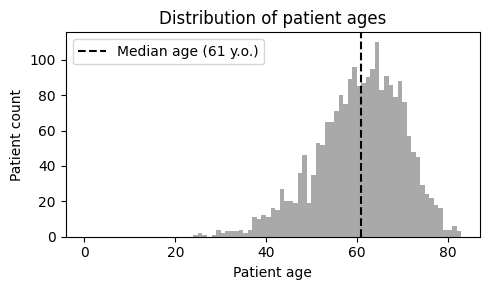

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

vs = pdf.demographics_age
ax.hist(vs, np.arange(0, vs.max() + 1), color="darkgray")

ax.axvline(vs.median(), color="black", label=f"Median age ({vs.median():.0f} y.o.)", linestyle="--")

ax.set_ylabel("Patient count")
ax.set_xlabel("Patient age")
ax.set_title("Distribution of patient ages")
ax.legend()

fig.tight_layout()
plt.show()

In [23]:
value_counts = []
for column in pdf.columns:
    if column not in ["patient_id", "cohort_id", "institution_name", "status_cohort_qualifier"]:
        vc = pdf[column].value_counts(dropna=False)
        value_counts.append(vc)
len(value_counts)

11

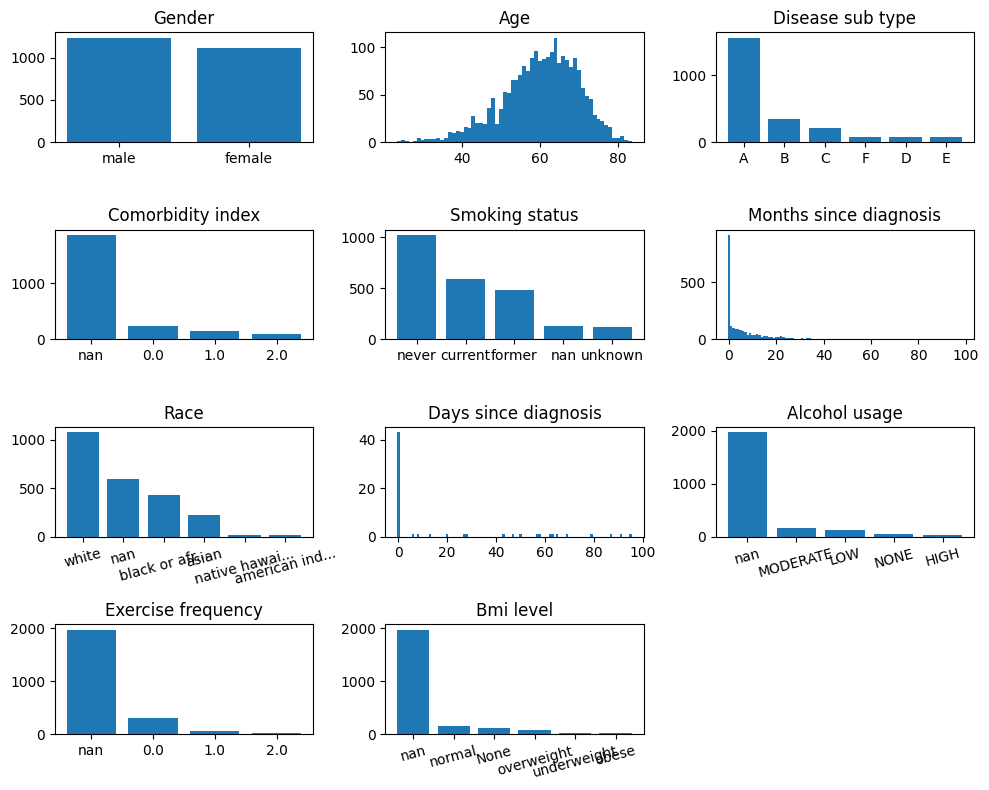

In [24]:
fig, axes = plt.subplots(4, 3, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):
    if i >= len(value_counts):
        ax.set_axis_off()
        continue
    vc = value_counts[i]
    ax.set_title(normalize_name(vc.name))
    if len(vc) > 20:
        if vc.name == "status_days_since_diagnosis":
            vc = vc[vc.index < 100]
        ax.bar(vc.index, vc, log=False, width=1)
    else:
        ax.bar(range(len(vc)), vc)
        labels = [str(v)[:12] + "..." if len(str(v)) > 15 else str(v) for v in vc.index]
        ax.set_xticks(range(len(vc)), labels=labels, rotation=15 if any(len(v) > 7 for v in labels) else 0)

fig.tight_layout()
plt.show()